# GOAL OF OUR PROJECT:
To identify all customers who are at risk of leaving (churners), so that the company can act (e.g., offer discounts, call them, give loyalty rewards).

# We will be focusing on maximising our Recall rate in this project..Why?
Think of churn prediction like security at an airport:

It's better to flag a few innocent people (low precision)

Than to miss an actual threat (low recall)

Similarly, it's better to reach out to 100 people, even if only 50 would have left — rather than missing 20 who silently leave and take their money with them.

# What is Recall?
Recall = TP / (TP + FN)
→ Of all actual churners, how many did we correctly predict?

If recall is low, you’re missing many real churners, which is very costly for a business.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('Bank Customer Churn Prediction.csv')

In [3]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.value_counts('churn')

churn
0    7963
1    2037
Name: count, dtype: int64

# Lets drop columns which does make any affect on Churn rate

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [6]:
categories_rows = ["country", "gender", "active_member", "credit_card"]
numeric_rows = ["credit_score", "age", "tenure", "balance", "products_number", "estimated_salary"]

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

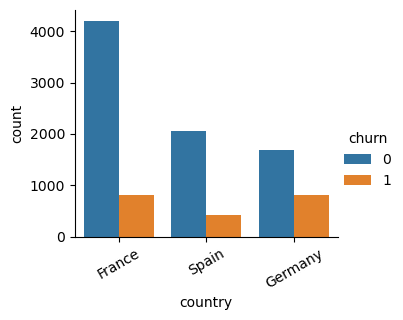

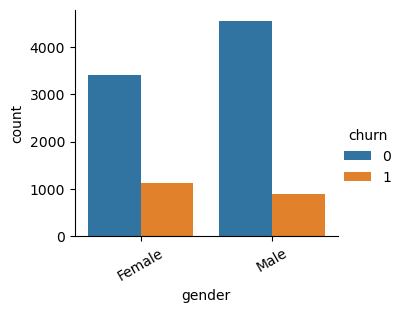

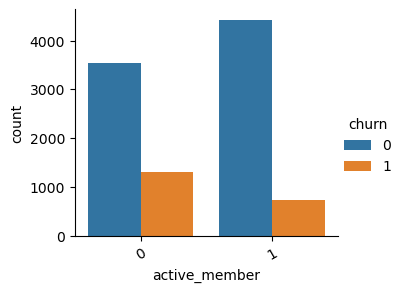

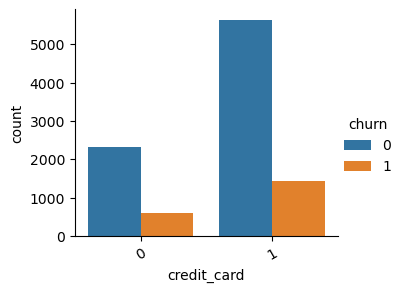

In [8]:
for col in categories_rows:
    g = sns.catplot(
        data=df, kind="count", x=col, hue="churn",
        height=3, aspect=1.2  # smaller plot size
    )
    g.set_xticklabels(rotation=30)

In [9]:
df.drop(columns=["customer_id"], inplace=True)

In [10]:
from sklearn.preprocessing import LabelEncoder

In [11]:
df = pd.get_dummies(df, columns=["country","gender", "active_member", "credit_card"], dtype=int)

In [12]:
df.head()

,credit_score,age,tenure,balance,products_number,estimated_salary,churn,country_France,country_Germany,country_Spain,gender_Female,gender_Male,active_member_0,active_member_1,credit_card_0,credit_card_1
0,619,42,2,0.00,1,101348.88,1,1,0,0,1,0,0,1,0,1
1,608,41,1,83807.86,1,112542.58,0,0,0,1,1,0,0,1,1,0
2,502,42,8,159660.80,3,113931.57,1,1,0,0,1,0,1,0,0,1
3,699,39,1,0.00,2,93826.63,0,1,0,0,1,0,1,0,1,0
4,850,43,2,125510.82,1,79084.10,0,0,0,1,1,0,0,1,0,1


In [13]:
X = df.drop(columns=["churn"])
y = df["churn"]

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.33, random_state=42, stratify=y,shuffle=True)

In [16]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [17]:
preprocessor = ColumnTransformer(
    transformers=[
        ('scaler', StandardScaler(), ['balance', 'estimated_salary','credit_score','age']) 
    ],
    remainder='passthrough' # Keep other columns as they are
)

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# XGB Classifier

In [19]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

In [20]:
model = XGBClassifier(eval_metric='logloss')

In [21]:
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', model)
])

In [22]:
# Define scale_pos_weight for imbalance handling
scale_pos_weight = (len(y_train) - sum(y_train)) / sum(y_train)

In [ ]:
# Param grid for tuning
param_grid = {
    'n_estimators': [270,280,290,300,320],
    'max_depth': [3,4,5,6,7],
    'learning_rate': [0.001,0.002,0.01,0.003],
    'scale_pos_weight': [scale_pos_weight],
    'gamma': [0,1,2,3,4,5], # gamma is the minimum improvement needed to justify a new branch on a tree.
    'reg_alpha': [0, 0.1, 1, 5] #alpha helps the model stay simple by removing unnecessary stuff.
}


In [45]:
# Grid search
grid = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='recall',
    cv=3,
    verbose=1,
    n_jobs=-1
)

In [46]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 2400 candidates, totalling 7200 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'gamma': [0, 1, 2, 3, 4, 5],
                         'learning_rate': [0.001, 0.002, 0.01, 0.003],
                         'max_depth': [3, 4, 5, 6, 7],
                         'n_estimators': [270, 280, 290, 300, 320],
                         'reg_alpha': [0, 0.1, 1, 5],
                         'scale_pos_weight': [3.9084249084249083]},
             scoring='recall', verbose=1)

In [47]:
predictions = grid.predict(X_test)

In [48]:
from sklearn.metrics import classification_report, confusion_matrix

In [49]:
print(classification_report(y_test, predictions)) 

              precision    recall  f1-score   support

           0       0.93      0.77      0.84      2628
           1       0.47      0.79      0.59       672

    accuracy                           0.77      3300
   macro avg       0.70      0.78      0.71      3300
weighted avg       0.84      0.77      0.79      3300



In [50]:
grid.best_params_

{'gamma': 5,
 'learning_rate': 0.001,
 'max_depth': 6,
 'n_estimators': 320,
 'reg_alpha': 5,
 'scale_pos_weight': 3.9084249084249083}

In [51]:
import numpy as np

print(np.unique(y_test))

[0 1]


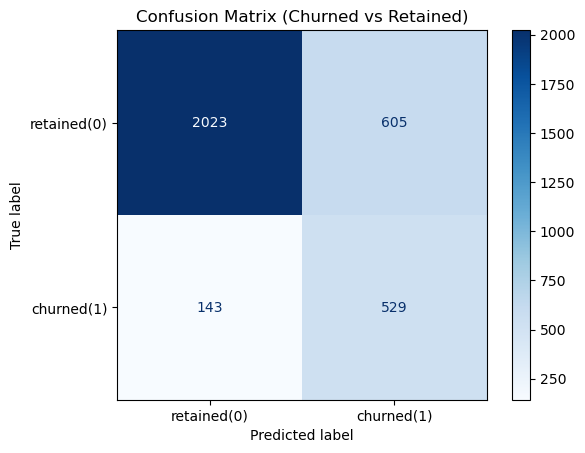

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Generate confusion matrix
cm = confusion_matrix(y_test, predictions)

# Display as a heatmap-style matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['retained(0)','churned(1)'])
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix (Churned vs Retained)')
plt.show()